In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [461]:
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import json
# import h5py

srcDir = r"d:/OneDrive - The University of Western Ontario/Documents/PhD/Thesis/CodeRepositories/windCalc/src"
if srcDir not in sys.path:
    sys.path.append(srcDir)

import windIO
import wind
import windWT as wt
import windCAD
import windOF as foam
import windCodes
import structure as strct

import winsound

from matplotlib.ticker import FuncFormatter

In [4]:
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# TTU building

In [1]:
B = 0.2744
D = 0.183
lScl=1/50.0

Hr = 0.08  # ridge height
roofSlope = np.rad2deg(np.arctan(0.25/12))  # roof slope
He = Hr - D/2.0*np.sin(np.deg2rad(roofSlope))  # eaves height
Havg = np.mean([Hr, He])
H = Havg  # average roof height
g = 0.016 # exploded plot gaps
print("Hr = {:.5g} m, He = {:.5g} m, Havg = {:.5g} m".format(Hr, He, Havg))

areaFactor_toFSm2 = (1/lScl**2)   # convert mm2 to m2 and normalize by the square of the length scale

fluidDensity = 1.225  # only for wind tunnel
fluidKinematicViscosity = 1.48e-5

badTaps = None
# badTaps = [1316, 1807, 2609,]
badTaps = [1807, 2609,]


NameError: name 'np' is not defined

In [6]:
tapFile = r"D:/tempData_depot/simData_CandC/tngTapDefinition.csv"
tapInfo = pd.read_csv(tapFile)

faceID = [1,2,3,4,5,6]
name = ['Roof_1','Roof_2','Wall_1','Wall_2','Wall_3','Wall_4']
note = ['','','','','','']

rs = np.deg2rad(roofSlope)
origin = [[0,0,Hr], # Face 1 (Roof_1)
          [0,0,He+D/2*np.tan(rs)], # Face 2 (Roof_2)
          [0,g+Hr-(B/2+g+Hr),B/2+g+Hr],  # Face 3 (Wall_1)
          [D/2,0,He+g+D/2],  # Face 4 (Wall_2)
          [0,(B/2+g+Hr)-(g+Hr),(B/2+g+Hr)],  # Face 5 (Wall_3)
          [-D/2,0,He+g+D/2],  # Face 6 (Wall_4)
          ] 

basisVectors = [[[np.cos(rs),0,np.sin(rs)],[0,1,0],[np.sin(rs),0,-np.cos(rs)]],
                [[np.cos(rs),0,-np.sin(rs)],[0,1,0],[-np.sin(rs),0,-np.cos(rs)]],
                [[1,0,0],[0,0,1],[0,1,0]],
                [[0,0,-1],[0,1,0],[-1,0,0]],
                [[1,0,0],[0,0,-1],[0,-1,0]],
                [[0,0,1],[0,1,0],[1,0,0]],]

origin_plt = [[0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              ]

basisVectors_plt = [[[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    ]
vertices = [[[-0.091519855,-0.1372],[0,-0.1372],[0,0.1372],[-0.091519855,0.1372],[-0.091519855,-0.1372]],
            [[0,-0.1372],[0.091519855,-0.1372],[0.091519855,0.1372],[0,0.1372],[0,-0.1372]],
            [[-0.0915,-0.2332],[0.0915,-0.2332],[0.0915,-0.15510625],[0,-0.1532],[-0.0915,-0.15510625],[-0.0915,-0.2332]],
            [[0.107519855,-0.1372],[0.185613605,-0.1372],[0.185613605,0.1372],[0.107519855,0.1372],[0.107519855,-0.1372]],
            [[-0.0915,0.2332],[0.0915,0.2332],[0.0915,0.15510625],[0,0.1532],[-0.0915,0.15510625],[-0.0915,0.2332]],
            [[-0.107519855,-0.1372],[-0.185613605,-0.1372],[-0.185613605,0.1372],[-0.107519855,0.1372],[-0.107519855,-0.1372]],]



In [219]:
faces_ASCE = []
for i,f in enumerate(faceID):
    idx = tapInfo.index[tapInfo.faceID == f]
    tapCoords = np.transpose(np.array([tapInfo.x[idx], tapInfo.y[idx]]))
    tapNos = np.array(tapInfo.tapNo[idx],dtype=int)
    idxOrig = idx

    fc = windCAD.face(
                name=name[i],
                ID=f,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=None,
                tapCoord=tapCoords,
                )
    faces_ASCE.append(fc)

Generating panels ...
Generating panels ...
Generating panels ...
Generating panels ...
Generating panels ...
Generating panels ...


In [220]:
bldg_ttu = wind.bldgCp(bldgName='TTU_1to50_TNG',
                faces=faces_ASCE,
                H=H, He=He, Hr=Hr,
                D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName='GeomDefinition',
                AoA_zero_deg_basisVector=[1,0],
                AoA_rotation_direction='CCW',
                )
print(json.dumps(bldg_ttu.panelingErrors, indent=4, separators=(',', ':')))

Refreshing GeomDefinition...
Verifying data ...
Done refreshing GeomDefinition.

{
    "Face 1":null,
    "Face 2":null,
    "Face 3":null,
    "Face 4":null,
    "Face 5":null,
    "Face 6":null
}


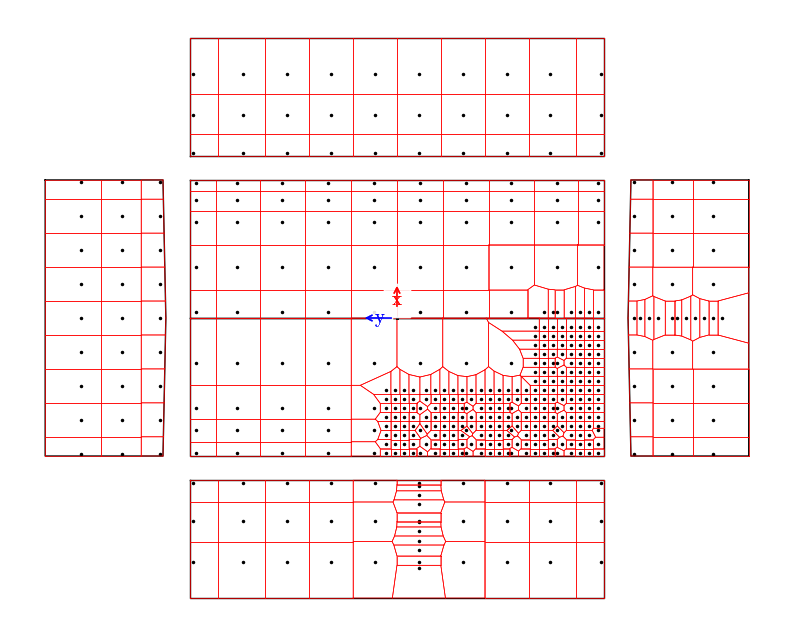

In [221]:
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)

bldg_ttu.plotEdges(ax=ax,showName=False)
bldg_ttu.plotTaps(ax=ax)
bldg_ttu.plotTribs(ax=ax)
bldg_ttu.plotLocalAxes(ax=ax,vectorSize=0.5)
# bldg.plotZones(ax=ax,showLegend=False)
# bldg.plotPanels(ax=ax,)

ax.set_aspect('equal')
_ = ax.axis('off')


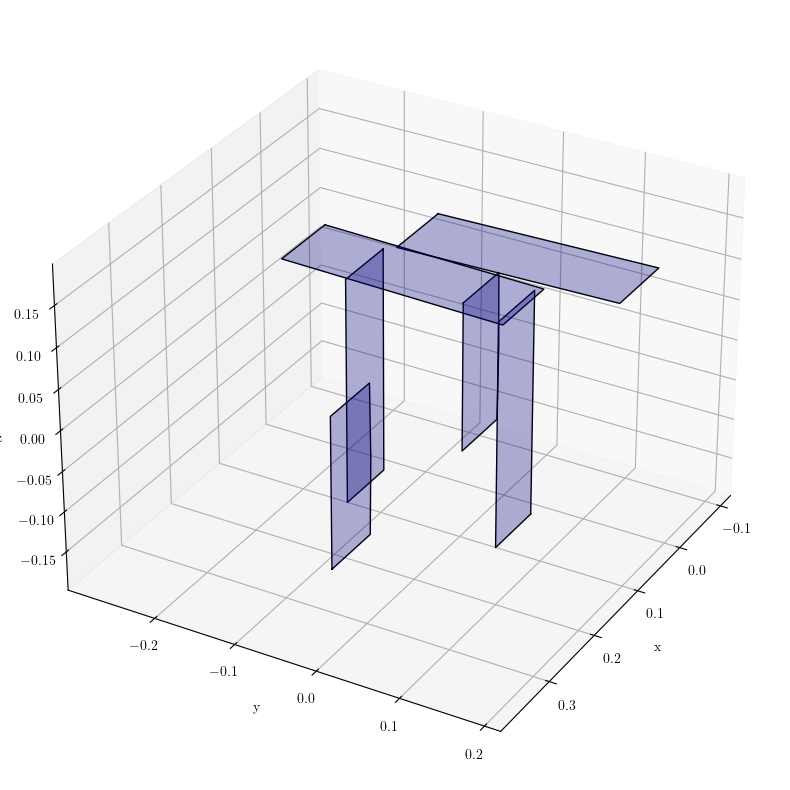

In [222]:
# fig = plt.figure(figsize=[15,15])
# ax = fig.add_subplot(111)

bldg_ttu.plotBldg_3D()

# ax.set_aspect('equal')
# _ = ax.axis('off')

# NRC building

In [120]:
# Directories
rawHFPIdir = r"F:/nrcNB_windTunnelData/rawHFPI/"
workDir = r"D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/"
rawVelDir = workDir + r"Data/windTunnel/profiles/"
outputDir = workDir + r"Data/windTunnel/"
figDir = outputDir + r"__plots/"

# Files
tapFile = workDir + r"Drawings/nrcNBwtTapDefinition.csv"


In [121]:
saveFigs = True
exps = ['E2','E3']
cases = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
exp = exps[0]
caseID = cases[1]

caseToRun = 'nrcNB'+caseID+exp
casedir = rawHFPIdir+caseToRun+r"/"

profileDir = rawVelDir #+'tng'+exp+'/'

In [375]:
rawHFPIdir = r"F:/nrcNB_windTunnelData/rawHFPI/"
workDir = r"D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/"
rawVelDir = workDir + r"Data/windTunnel/profiles/"
outputDir = workDir + r"Data/windTunnel/gable27deg/"
figDir = outputDir + r"__plots/"
exportDir = outputDir + r"__export/"

# Files
tapFile = workDir + r"Drawings/nrcNBwtTapDefinition.csv"

H = 80*wind.UNIT_CONV['mm2m']  # average roof height
Hr = 97.5*wind.UNIT_CONV['mm2m']  # ridge height
He = 62.5*wind.UNIT_CONV['mm2m']  # eaves height
Havg = np.mean([Hr, He])
B = 410*wind.UNIT_CONV['mm2m']
D = 138.7*wind.UNIT_CONV['mm2m']
roofSlope = 26.1  # roof slope
site_latitude = 46.1

lScl=1/100.0
vScl=1/2.78
tScl=lScl/vScl

areaFactor_toFSm2 = 1/(1000**2)*(1/lScl**2)   # convert mm2 to m2 and normalize by the square of the length scale
dur_MS_1hr = 3600*tScl
badTaps = []

print("lScl = {:.5f}".format(lScl))
print("tScl = {:.5f}".format(tScl))
print("vScl = {:.5f}".format(vScl))
print(f"Model-scale duration = {dur_MS_1hr:.2f} seconds")

lScl = 0.01000
tScl = 0.02780
vScl = 0.35971
Model-scale duration = 100.08 seconds


In [376]:

tapData = pd.read_csv(tapFile, na_filter=False)
all_fullScaleTaps=  [101, 111, 102, 112, 109, 110, 1911, 104, 106, 405, 314, 212, 316, 402, 301]
all_fullScaleTaps=  [101, 111, 102, 112, 109, 110, 2004, 104, 106, 405, 314, 212, 316, 402, 301]
fullScaleTaps=      [101, 111, 102, 112, 109, 110, 104, 106, 405, 314, 212, 316, 402, 301]  # remove 1911 (PT7)

faceID = [1,2,3,4,5,6]
name = [r'West roof',r'East roof',r'East wall',r'North wall',r'West wall',r'South wall']
note = ['','','','','','']
origin = [[0, -71.6, 62.5], [0, 71.6, 62.5], [0, 69.35, 0], [-205, 0, 0], [0, -69.35, 0], [205, 0, 0], ]

basisVectors = [[[1, 0, 0], [0, 0.898027575760616, -0.439939169855915], [0, 0.439939169855915, 0.898027575760616]], 
                [[-1, 0, 0], [0, -0.898027575760616, 0.439939169855915], [0, 0.439939169855915, 0.898027575760616]], 
                [[-1, 0, 0], [0, 0, 1], [0, 1, 0]], 
                [[0, 0, -1], [-1, 0, 0], [0, 1, 0]], 
                [[1, 0, 0], [0, 0, -1], [0, 1, 0]], 
                [[0, 0, 1], [1, 0, 0], [0, 1, 0]], 
                ]

# origin_plt = [[0, 79.6967], [0, -79.6967], [0, -223.5182], [-357.0189, 0], [0, -223.5182], [357.0189, 0], ]
origin_plt = [[0, -79.6967], [0, -79.6967], [0, -150], [0, -320], [0, -150], [0, -320], ]

basisVectors_plt = [
            [[1, 0], [0, 1]],       # Face 1 (West_roof)
            [[-1, 0], [0, -1]],     # Face 2 (East_roof)
            [[-1, 0], [0, -1]],     # Face 3 (East_wall)
            [[0, 1], [-1, 0]],      # Face 4 (North_wall)
            [[1, 0], [0, 1]],       # Face 5 (West_wall)
            [[0, -1], [1, 0]],      # Face 6 (South_wall)
            ]

vertices_basic = [
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 1
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 2
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 3
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 4
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 5
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 6
            ]


In [377]:
# nominalPanelAreas = [4.4e-5, 8.15e-5, 1.3e-4, 5e-4, 6.8e-4, 1.3e-3,],   # Final! All are tested. 1.3e-3 results in blunt edge zones in the walls but no error.
nominalPanelAreas = [50.0, 180.0, 470.0, 785.0, 3200, 10000]

faces = []
for i,z in enumerate(faceID):
    print(f"Processing face {z}...")
    idx = tapData.index[tapData.faceID == z]
    tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
    tapNos = np.array(tapData.tapNo[idx],dtype=int)
    tapName = tapData.tapName[idx]
    idxOrig = idx
    if z == 2:  # flip the y-coordinates about the centreline defined by average of the edge vertices. 
                # The aerodynamics strongly suggests that Face 2 must have been flipped in the tubing process.
        x = np.array(vertices_basic[i])
        yAvg = np.mean([min(x[:,1]), max(x[:,1])])
        tapCoords[:,1] = yAvg - (tapCoords[:,1] - yAvg)

    fc = windCAD.face(
                name=f'Face {z} ('+name[i]+')',
                ID=z,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices_basic[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=tapName,
                tapCoord=tapCoords,
                # zoneDict=zoneDict_basic[i],
                # nominalPanelAreas=nominalPanelAreas, 
                showDetailedLog=False,
                )
    faces.append(fc)
    fc.error_in_panels
    print(f"Face {z} done.\n\n\n")


Processing face 1...
Generating panels ...
Face 1 done.



Processing face 2...
Generating panels ...
Face 2 done.



Processing face 3...
Generating panels ...
Face 3 done.



Processing face 4...
Generating panels ...
Face 4 done.



Processing face 5...
Generating panels ...
Face 5 done.



Processing face 6...
Generating panels ...
Face 6 done.





In [378]:
bldg_iso = wind.bldgCp(bldgName=r'NRC-NB 1:100 UWO',
                faces=faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=[-1,0],
                AoA_rotation_direction='cw',
                caseName=r'Case 2 [x]',
                notes_Cp=r'Generic isolated case.',
                )

Refreshing Case 2 [x]...
Verifying data ...
Done refreshing Case 2 [x].



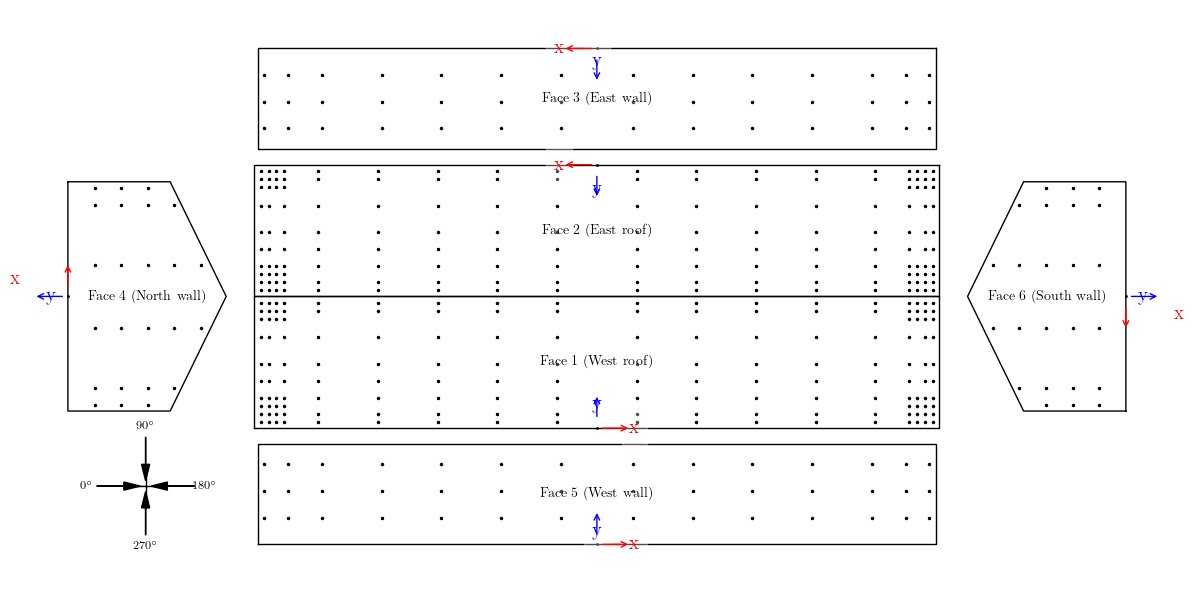

In [380]:
fig = plt.figure(figsize=[12,6])
axs = fig.subplots(1,1)
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

ax = axs
# ax.text(0.5, 0.95, r'(a) Isolated', transform=ax.transAxes, ha='center', va='bottom', fontsize=14)
bldg_iso.plotEdges(ax=ax,showName=True)
bldg_iso.plotTaps(ax=ax,showTapNo=False)
# bldg_iso.plotTribs(ax=ax,)
bldg_iso.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5])
bldg_iso.plotLocalAxes(ax=ax, vectorSize=0.4)
ax.axis('equal')
ax.axis('off')


plt.show()

# # if saveFigs:
# fig.savefig(figDir+"tapLayout_tex.svg",format='svg',dpi=1200, bbox_inches='tight')


In [381]:
print(bldg_iso[0].tapTribs.geoms[0])

POLYGON ((207.25 0, 201.04 0, 201.04 6.21, 207.25 6.21, 207.25 0))


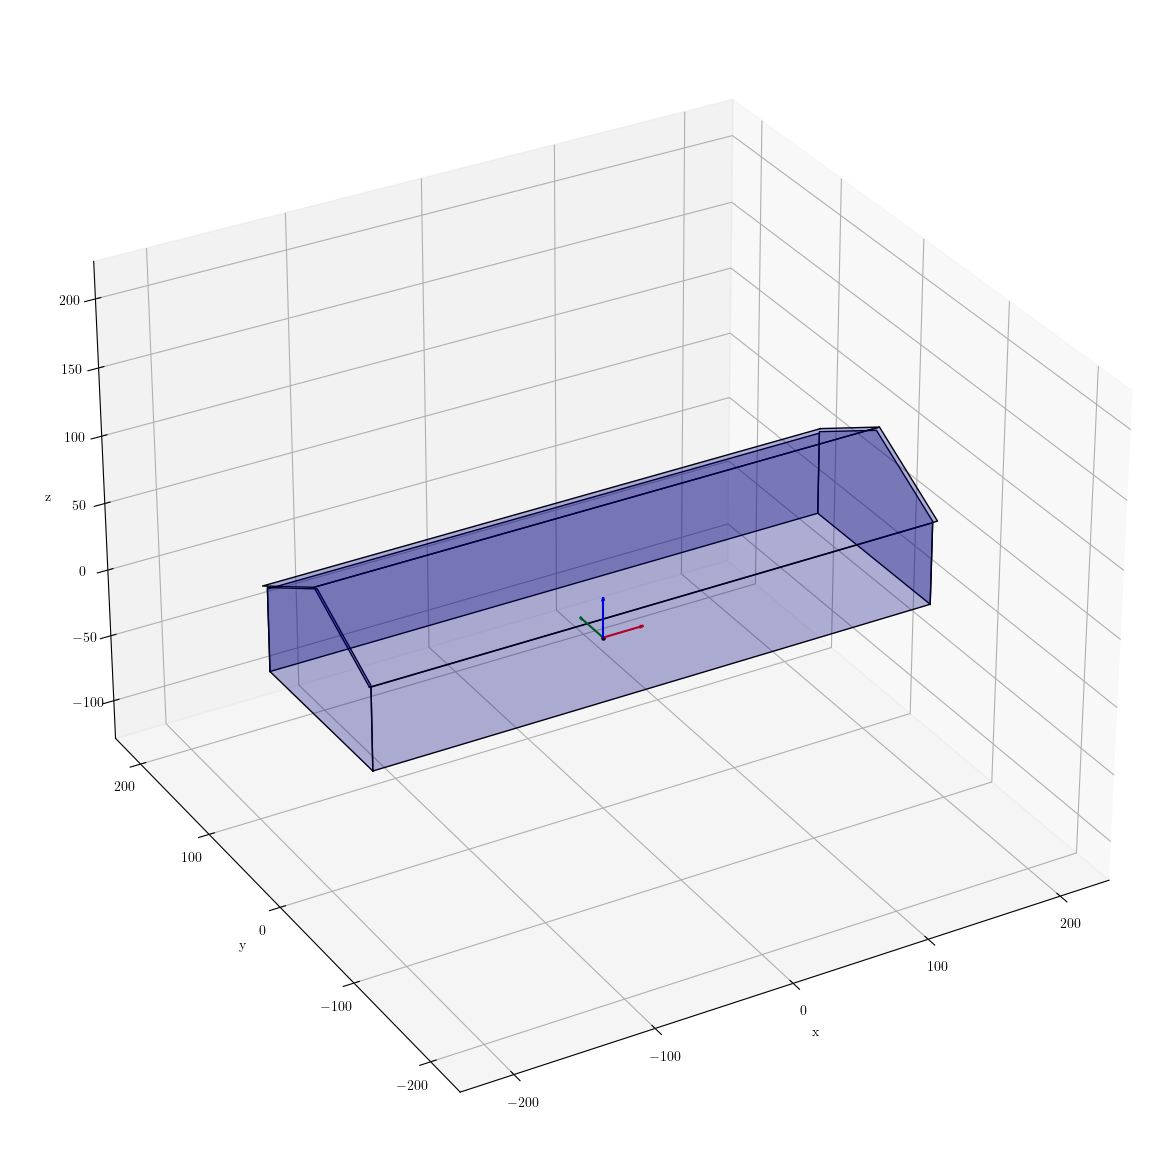

In [382]:
bldg_iso.plotBldg_3D(figsize=[15,15],
                     kwargs_view={'elev': 30, 'azim': -120}, showAxis=True, showOrigin=True, axisArrowSize=30, axisVisibility='on',
                     )


In [383]:
analogChannels_idxs={
                'main_pitot': 0,
                'xref_pitot': 2,
            }
pressureExtraChannels_tapNos={
                'main_pitot_zero': 2909,
                'main_pitot_queue': 2910,
                '20inch_pitot_zero': 2907,
                '20inch_pitot_queue': 2908,
                'Uh_pitot_zero': 2905,
                'Uh_pitot_queue': 2906,
            }

peakSpecs = wind.DEFAULT_PEAK_SPECS
# peakSpecs = {
#                 'method':'minmax',
#             }
peakSpecs['Num_seg'] = 10
peakSpecs['Duration'] = 10
peakSpecs['prob_non_excd'] = 0.8

In [130]:

cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=200.0,
    # lowpassFreq=222.223,
    Ntaps=440,
)
winsound.Beep(1000, 1000)
print((cp_raw.CpTH.shape))

Reading HFPI data from: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P001a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P002a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P003a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P004a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P005a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P006a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P007a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P008a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P009a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P010a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R0

In [131]:
sFreq = 1600
dt = 1/sFreq

pDir =profileDir+"tngE2/"
Z = np.squeeze(pd.read_csv(pDir+"Z.csv"))
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")
W_TH = np.load(pDir+"WofT.npy")
vel_OP = wind.profile(name="BLWT - OP", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=32,keepTH=True)

pDir =profileDir+"tngE3/"
Z = np.squeeze(pd.read_csv(pDir+"Z.csv"))
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")
W_TH = np.load(pDir+"WofT.npy")
vel_SU = wind.profile(name="BLWT - SU", Z=Z,UofT=U_TH.transpose(),VofT=V_TH.transpose(),WofT=W_TH.transpose(),H=H,dt=dt,nSpectAvg=32,keepTH=True)

del(U_TH, V_TH, W_TH)

In [132]:
if exp == 'E2':
    z0 = 0.02
    vel_WT = vel_OP
elif exp == 'E3':
    z0 = 0.2
    vel_WT = vel_SU

es85 = wind.ESDU85(z0=0.02, Zref=H/lScl, Uref=25.0)
es74 = wind.ESDU74(z0=0.02, Zref=H/lScl, Uref=25.0)
vel_E2_ESDU = es85.toProfileObj()
vel_E2_ESDU.SpectH = es74.toProfileObj().SpectH
vel_E2_ESDU.name = r'ESDU ($z_0=0.02m$)'
vel_E2_ESDU.SpectH.name = r'ESDU ($z_0=0.02m$)'

es85 = wind.ESDU85(z0=0.2, Zref=H/lScl, Uref=25.0)
es74 = wind.ESDU74(z0=0.2, Zref=H/lScl, Uref=25.0)
vel_E3_ESDU = es85.toProfileObj()
vel_E3_ESDU.SpectH = es74.toProfileObj().SpectH
vel_E3_ESDU.name = r'ESDU ($z_0=0.2m$)'
vel_E3_ESDU.SpectH.name = r'ESDU ($z_0=0.2m$)'

vel = wind.Profiles([vel_OP, vel_E2_ESDU, vel_SU, vel_E3_ESDU])

Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
Message from ESDU74: Functionality for uncertainty bounds is not implemented yet.
No velocity time history found for ESDU-85 ($z_0=0.02 m$). Skipping velocity statistics calculation.
No velocity time history found for ESDU-74 ($z_0=0.02 m$). Skipping velocity statistics calculation.
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
Message from ESDU74: Functionality for uncertainty bounds is not implemented yet.
No velocity time history found for ESDU-85 ($z_0=0.2 m$). Skipping velocity statistics calculation.
No velocity time history found for ESDU-74 ($z_0=0.2 m$). Skipping velocity statistics calculation.


In [384]:
bldg_iso_cp = wind.bldgCp(
                bldgName=f"nrcNB{caseID}{caseID}",
                faces=faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName=caseToRun,
                refProfile=vel_WT,
                Zref_input=cp_raw.Z_MainPitot,
                A_ref=[D*H, B*H, D*B],
                Uref_input=cp_raw.Uref,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH,
                # badTaps=None,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=True,
                )
winsound.Beep(1000, 1000)

Re-scaling profile to match Uref ...
    Uref_avg = 12.149 m/s
    U_ref_prof = 12.542 m/s
    U_ratio = 0.969
    time_ratio = 1.032
Refreshing nrcNBc2E2...
Verifying data ...
Computing Cp statistics ...
Done refreshing nrcNBc2E2.



## Structural

In [469]:
structFile = workDir + r"Drawings/24-10-24_NB_27deg_StructGeom.xlsx"

sheetName = 'nodes'
nodes_df = pd.read_excel(structFile, sheet_name=sheetName, header=0, index_col=0)
nodes_df['name'] = nodes_df['name'].fillna('')
print("Nodes:")
print(nodes_df)

sheetName = 'elements'
elems_df = pd.read_excel(structFile, sheet_name=sheetName, header=0, index_col=0)
elems_df['name'] = elems_df['name'].fillna('')
elems_df['internalNodes'] = elems_df['internalNodes'].apply(lambda x: [int(i) for i in x.split(',')])
print("Elements:")
print(elems_df)

sheetName = 'panels'
panels_df = pd.read_excel(structFile, sheet_name=sheetName, header=0, index_col=0)
panels_df['nodes'] = panels_df['nodes'].apply(lambda x: [int(i) for i in x.split(',')])
print("Panels:")
print(panels_df)

sheetName = 'frames'
frames_df = pd.read_excel(structFile, sheet_name=sheetName, header=0, index_col=0)
frames_df['nodes'] = frames_df['nodes'].apply(lambda x: [int(i) for i in x.split(',')])
frames_df['elements'] = frames_df['elements'].apply(lambda x: [int(i) for i in x.split(',')])
print("Frames:")
print(frames_df)

Nodes:
   name  frame connectionType  nodeType    x        y       z  dof_0  dof_1  \
ID                                                                            
0     A      0          fixed   support  100 -69.3500   0.000      1      1   
1            0          fixed  internal  100 -69.3500  20.620      0      0   
2            0          fixed  internal  100 -69.3500  41.240      0      0   
3     B      0          fixed     joint  100 -69.3500  61.860      0      0   
4            0          fixed  internal  100 -52.0125  70.335      0      0   
5            0          fixed  internal  100 -34.6750  78.810      0      0   
6            0          fixed  internal  100 -17.3375  87.285      0      0   
7     C      0            pin     joint  100   0.0000  95.760      0      0   
8            0          fixed  internal  100  17.3375  87.285      0      0   
9            0          fixed  internal  100  34.6750  78.810      0      0   
10           0          fixed  internal  100 

In [470]:
nodes = []
for i, row in nodes_df.iterrows():
    # # read fixedDOF from columns 'dof_0' to 'dof_5' and convert to a list of bools
    # fixedDOF = [bool(row[f'dof_{j}']) for j in range(6)]
    n = strct.node(x=row['x'], y=row['y'], z=row['z'], name=row['name'], ID=i, 
                            fixedDOF=[bool(row[f'dof_{j}']) for j in range(6)],
                        #  connectionType=row['connectionType'], 
                         nodeType=row['nodeType'],
                         )
    # print(str(n)+'\n')
    nodes.append(n)
    
elems = []
for i, row in elems_df.iterrows():
    e = strct.element(name=row['name'], ID=i, startNode=nodes[row['startNode']], endNode=nodes[row['endNode']],
                            internalNodes=[nodes[j] for j in row['internalNodes']], 
                         )
    # print(str(e)+'\n')
    elems.append(e)
    
panels = []
for i, row in panels_df.iterrows():
    face_IDs = [f.ID for f in bldg_iso_cp]
    face_idx = face_IDs.index(row['face'])
    p = strct.panel(ID=i, supportNodes=[nodes[j] for j in row['nodes']], parentFace=bldg_iso_cp[face_idx], 
                          vertices=np.array([nodes[j].loc for j in row['nodes']]), parentBldg=bldg_iso_cp, 
                         )
    # print(str(p)+'\n')
    panels.append(p)
        
frames = []
for i, row in frames_df.iterrows():
    f = strct.frame2D(ID=i, parentBuilding=bldg_iso_cp, name=row['name'],
                            nodes=[nodes[j] for j in row['nodes']], elements=[elems[j] for j in row['elements']])
    print(str(f)+'\n')
    frames.append(f)

Frame ID:	0
name:		ABCDE
Building:	nrcNBc2E2
Nodes:		[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Elements:	[0, 1, 2, 3]

Frame ID:	1
name:		FGHIJ
Building:	nrcNBc2E2
Nodes:		[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Elements:	[4, 5, 6, 7]

Frame ID:	2
name:		KLMNO
Building:	nrcNBc2E2
Nodes:		[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
Elements:	[8, 9, 10, 11]



In [471]:
# create backwards connectivity between:
# - panels as properties of nodes
# - elements as properties of nodes
# - frames as properties of nodes
# - panels as properties of elements
# - frames as properties of elements

for n in nodes:
    n.connectedPanels = [p for p in panels if n in p.supportNodes]
    n.connectedElements = [e for e in elems if n in e.nodes]
    n.parentFrame = [f for f in frames if n in f.nodes][0]
    
for e in elems:
    e.parentFrame = [f for f in frames if e in f.elements][0]

In [472]:
frm = frames[0]
Cf = frm.Cf_Stats

d:\OneDrive - The University of Western Ontario/Documents/PhD/Thesis/CodeRepositories/windCalc/src\windCAD.py:3070: UserWarning: Panel 2 area (1030.9999999999998) and the sum of overlapping tap areas (975.9999999999998) do not match within a tolerance of 1e-6.
  ax.text(self.centroid_global[0]+textOffset[0], self.centroid_global[1]+textOffset[1], str(self.ID), **kwargs_text)
d:\OneDrive - The University of Western Ontario/Documents/PhD/Thesis/CodeRepositories/windCalc/src\windCAD.py:3070: UserWarning: Panel 2 area (1030.9999999999998) and the sum of overlapping tap areas (975.9999999999998) do not match within a tolerance of 1e-6.
  ax.text(self.centroid_global[0]+textOffset[0], self.centroid_global[1]+textOffset[1], str(self.ID), **kwargs_text)
d:\OneDrive - The University of Western Ontario/Documents/PhD/Thesis/CodeRepositories/windCalc/src\windCAD.py:2926: UserWarning: Panel 3 has non-zero local z values. Setting them to zero.
  def supportLocations_global(self) -> np.ndarray:
d:\On

In [474]:
print(np.shape(Cf['mean']))


(40, 3, 15)


(40, 3, 4, 36000)
[0.25 0.25 0.25 0.25]


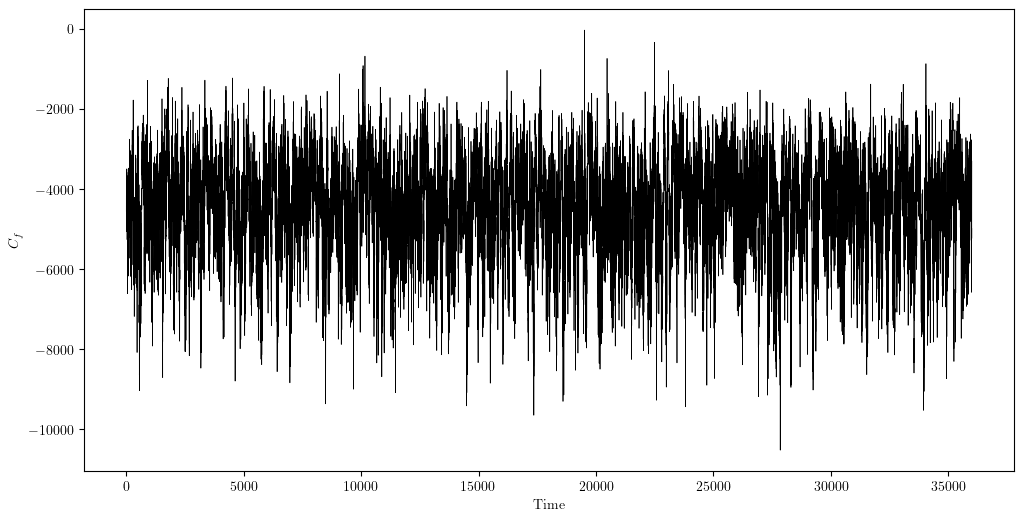

In [462]:
pnl = panels[0]
# pnl = strct.panel()
# print(pnl.parentFace.name)
# print(pnl.corners_local)
cf = pnl.Cf_TH_atSupports

print(cf.shape)
print(pnl.supportAreaShares_normalized)

cf_mean = np.mean(cf, axis=3)
# print(cf_mean)

# shape: [nAoA, components, nSupports, nTime]
# plot time history of Cf_x at support i, AoA j
i = 1
j = 15
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
ax.plot(cf[j,1,i,:], 'k-',lw=0.5)
ax.set_xlabel('Time')
ax.set_ylabel(r'$C_f$')
plt.show()


In [412]:
fc = bldg_iso_cp[0]
# fc = wind.faceCp()

vertics_local = np.hstack([fc.vertices, np.zeros((len(fc.vertices),1))])

Origin_ofLocal_inGlobalSys = np.array(fc.origin)
basisVectors_local = np.array(fc.basisVectors)

# for Face 1
# basisVectors_local = np.array([[1,0,0],[0,0.898027575760616,-0.439939169855915],[0,0.439939169855915,0.898027575760616]]) 

# for Face 4: local x = global -y, local y = global z, local z = -global x
# basisVectors_local = np.array([[0,0,-1],[-1,0,0],[0,1,0]])

# for Face 5: local x = global x, local y = global z, local z = -global y
# basisVectors_local = np.array([[1,0,0],[0,0,-1],[0,1,0]])

# for Face 6: local x = global y, local y = global z, local z = global x (Face 4 mirrored about yz-plane)
# basisVectors_local = np.array([[0,0,1],[1,0,0],[0,1,0]])

basisVectors_global = np.array([[1.0,0,0],[0,1,0],[0,0,1]])

transformation_matrix_local2global = basisVectors_global @ np.linalg.inv(basisVectors_local)
transformation_matrix_global2local = np.linalg.inv(transformation_matrix_local2global)

vertices_global = vertics_local @ transformation_matrix_local2global + Origin_ofLocal_inGlobalSys

vertices_backToLocal = (vertices_global - Origin_ofLocal_inGlobalSys) @ transformation_matrix_global2local 

the_two_are_the_same = np.allclose(vertics_local, vertices_backToLocal)

print(f"Origin: {np.array2string(Origin_ofLocal_inGlobalSys, precision=4, separator=',', suppress_small=True)}\n")
print(f"Basis vectors (local):\n{np.array2string(basisVectors_local, precision=4, separator=',', suppress_small=True)}\n")
# print(f"Basis vectors (global):\n{np.array2string(basisVectors_global, precision=4, separator=',', suppress_small=True)}\n")

# print(f"Transformation matrix (local to global):\n{np.array2string(transformation_matrix_local2global, precision=4, separator=',', suppress_small=True)}\n")
# print(f"Transformation matrix (global to local):\n{np.array2string(transformation_matrix_global2local, precision=4, separator=',', suppress_small=True)}\n")

print(f"Local:\n{np.array2string(vertics_local, precision=4, separator=',', suppress_small=True)}\n")
print(f"Global:\n{np.array2string(vertices_global, precision=4, separator=',', suppress_small=True)}\n")
# print(f"Back to local:\n{np.array2string(vertices_backToLocal, precision=4, separator=',', suppress_small=True)}\n")
# print(f"Local and back to local are the same: {the_two_are_the_same} \n")

# print(f"Global (using the face object):\n{np.array2string(fc.toGlobalCoord(fc.vertices), precision=4, separator=',', suppress_small=True)}\n")

test_line_in_local_xDir = np.array([[0,0,0],[50,0,0]])
test_line_in_global_xDir = test_line_in_local_xDir @ transformation_matrix_local2global + Origin_ofLocal_inGlobalSys

test_line_in_local_yDir = np.array([[0,0,0],[0,100,0]])
test_line_in_global_yDir = test_line_in_local_yDir @ transformation_matrix_local2global + Origin_ofLocal_inGlobalSys

test_line_in_local_zDir = np.array([[0,0,0],[0,0,150]])
test_line_in_global_zDir = test_line_in_local_zDir @ transformation_matrix_local2global + Origin_ofLocal_inGlobalSys

# print the vertices_global in the command form for AutoCAD to draw a 3D polyline (3DPOLY)
print("3DPOLY")
for v in vertices_global:
    print(f"{v[0]:.4f},{v[1]:.4f},{v[2]:.4f}")
print("")
print("LINE")
for v in test_line_in_global_zDir:
    print(f"{v[0]:.4f},{v[1]:.4f},{v[2]:.4f}")
print("")
print("LINE")
for v in test_line_in_global_xDir:
    print(f"{v[0]:.4f},{v[1]:.4f},{v[2]:.4f}")
print("")
print("LINE")
for v in test_line_in_global_yDir:
    print(f"{v[0]:.4f},{v[1]:.4f},{v[2]:.4f}")
print("")
print("")



Origin: [  0. ,-71.6, 62.5]

Basis vectors (local):
[[ 1.    , 0.    , 0.    ],
 [ 0.    , 0.898 ,-0.4399],
 [ 0.    , 0.4399, 0.898 ]]

Local:
[[-207.25  ,   0.    ,   0.    ],
 [-207.25  ,  79.6967,   0.    ],
 [ 207.25  ,  79.6967,   0.    ],
 [ 207.25  ,   0.    ,   0.    ],
 [-207.25  ,   0.    ,   0.    ]]

Global:
[[-207.25  , -71.6   ,  62.5   ],
 [-207.25  ,  -0.0302,  97.5617],
 [ 207.25  ,  -0.0302,  97.5617],
 [ 207.25  , -71.6   ,  62.5   ],
 [-207.25  , -71.6   ,  62.5   ]]

3DPOLY
-207.2500,-71.6000,62.5000
-207.2500,-0.0302,97.5617
207.2500,-0.0302,97.5617
207.2500,-71.6000,62.5000
-207.2500,-71.6000,62.5000

LINE
0.0000,-71.6000,62.5000
0.0000,-137.5909,197.2041

LINE
0.0000,-71.6000,62.5000
50.0000,-71.6000,62.5000

LINE
0.0000,-71.6000,62.5000
0.0000,18.2028,106.4939




In [427]:
# ## testing panels: Panel idx 3 in Face 1 (idx 0)
pnl = panels[3]
# pnl = windCAD.panel_CAD()
fc = pnl.parentFace



pnlCrnr_global = pnl.vertices_global
# pnlCrnr_local = (pnlCrnr_global - Origin_ofLocal_inGlobalSys) @ transformation_matrix_global2local
pnlCrnr_local = (pnlCrnr_global - np.array(fc.origin)) @ np.array(fc.basisVectors)
pnlCrnr_local_builtin = pnl.vertices_local

print(f"Panel corners (global):\n{np.array2string(pnlCrnr_global, precision=4, separator=',', suppress_small=True)}\n")
print(f"Panel corners (local):\n{np.array2string(pnlCrnr_local, precision=4, separator=',', suppress_small=True)}\n")
print(f"Panel corners (local, built-in):\n{np.array2string(pnlCrnr_local_builtin, precision=4, separator=',', suppress_small=True)}\n")

print(f"====================\n\n")
print(f"Origin: {np.array2string(np.array(fc.origin), precision=4, separator=',', suppress_small=True)}\n")
print(f"Basis vectors (local):\n{np.array2string(np.array(fc.basisVectors), precision=4, separator=',', suppress_small=True)}\n")
# print(f"Vertices (local):\n{np.array2string(fc.vertices, precision=4, separator=',', suppress_small=True)}\n")


# print("3DPOLY")
# for v in pnlCrnr_global:
#     print(f"{v[0]:.4f},{v[1]:.4f},{v[2]:.4f}")
# print("")
# print("")
# print("3DPOLY")
# for v in pnlCrnr_local:
#     print(f"{v[0]:.4f},{v[1]:.4f},{v[2]:.4f}")
# print("")


Origin_ofLocal_inGlobalSys:
[  0. ,-71.6, 62.5]

basisVectors_local:
[[ 1.   , 0.   , 0.   ],
 [ 0.   , 0.898,-0.44 ],
 [ 0.   , 0.44 , 0.898]]

points_inGlobalCoords:
[[100.   ,-69.35 , 61.86 ],
 [100.   ,-52.013, 70.335],
 [150.   ,-52.013, 70.335],
 [150.   ,-69.35 , 61.86 ]]

transformation_matrix_global2local:
[[ 1.   , 0.   , 0.   ],
 [ 0.   , 0.898,-0.44 ],
 [ 0.   , 0.44 , 0.898]]

points_local:
[[100.   ,  1.739, -1.565],
 [100.   , 21.037, -1.581],
 [150.   , 21.037, -1.581],
 [150.   ,  1.739, -1.565]]

re-transformation successfull: True

Panel corners (global):
[[100.    ,-69.35  , 61.86  ],
 [100.    ,-52.0125, 70.335 ],
 [150.    ,-52.0125, 70.335 ],
 [150.    ,-69.35  , 61.86  ]]

Panel corners (local):
[[100.    ,  1.739 , -1.5646],
 [100.    , 21.037 , -1.5813],
 [150.    , 21.037 , -1.5813],
 [150.    ,  1.739 , -1.5646]]

Panel corners (local, built-in):
[[100.   ,  1.739,  0.   ],
 [100.   , 21.037,  0.   ],
 [150.   , 21.037,  0.   ],
 [150.   ,  1.739,  0.   ]]



d:\OneDrive - The University of Western Ontario/Documents/PhD/Thesis/CodeRepositories/windCalc/src\windCAD.py:2909: UserWarning: Panel 3 has non-zero local z values. Setting them to zero.
  @property


In [419]:
xgap = 1013.6
# create a list of numbers from 210 to 210+21*1013.6 with a step of 1013.6 (22 numbers) and the negative of that list together
x = np.arange(210, 210+21*xgap, xgap)
x = np.concatenate([x, -x])
# add to the list [-19215, -10822.5, -2430, 0, 2430, 10822.5, 19215]
x = np.concatenate([x, [-19215, -10822.5, -2430, 0, 2430, 10822.5, 19215]])
# sort the list in ascending order
x = np.sort(x)

y = [-1005, -665, 0, 665, 1005]
z = [0, 1500]

# create a vertical list of all possible combinations of x, y, and z to be exported to a CSV file
xyz = np.array(np.meshgrid(x, y, z)).T.reshape(-1,3)

file = r"D:\OneDrive - The University of Western Ontario\Documents\Projects\FM Global SATs\gridPoints.csv"
# export the file to a CSV file with the header "x,y,z"
np.savetxt(file, xyz, delimiter=',', header='x,y,z', comments='')

print(np.shape(xyz))

(490, 3)


# Scratch

In [18]:
vertices = [[[-5,0], [5,0], [5,4], [-5,4], [-5,0]],
            [[-5,0], [5,0], [5,4], [-5,4], [-5,0]],]

origin = [[5,2,0],
          [5,2,0],]

basisVectors = [[[0,0,-1],[-1/np.sqrt(2),1/np.sqrt(2),0],[1/np.sqrt(2),1/np.sqrt(2),0]],
                [[0,0,-1],[1/np.sqrt(2),1/np.sqrt(2),0],[1/np.sqrt(2),-1/np.sqrt(2),0]],
                ]

origin_plt = [[0, 0],
              [0, 2],
            ]

basisVectors_plt = [[[1, 0], [0, 1]],
                    [[1, 0], [0, -1]],
                    ]

faceIDs = [1,2]

faces = []
for i,z in enumerate(faceIDs):
    tapCoords = np.array([[-4,2], [3,3], [2,1], [-3,1], [0,3.5]],dtype=float)
    tapNos = np.array([101,102,103,104,105],dtype=int)
    tapName = ['A','B','C','D','E']
    idxOrig = [0,1,2,3,4]
    fc = windCAD.face(
                    name=f'Face {z}',
                    ID=z,
                    origin=origin[i],
                    basisVectors=basisVectors[i],
                    origin_plt=origin_plt[i],
                    basisVectors_plt=basisVectors_plt[i],
                    vertices=vertices[i],
                    tapNo=tapNos,
                    tapIdx=idxOrig,
                    tapName=tapName,
                    tapCoord=tapCoords,
                    showDetailedLog=False,
                    )
    faces.append(fc)
    fc.error_in_panels
  

Generating panels ...
Generating panels ...


In [19]:
bldg = wind.bldgCp(bldgName='Test',
                faces=faces,
                H=4,D=10,B=10,roofSlope=26.57,lScl=1,
                AoA_zero_deg_basisVector=[1,0],
                AoA_rotation_direction='CCW',
                caseName='Test',
                notes_Cp='Test',
                )

Refreshing Test...
Verifying data ...
Done refreshing Test.



(-5.5, 5.5, -6.5, 4.5)

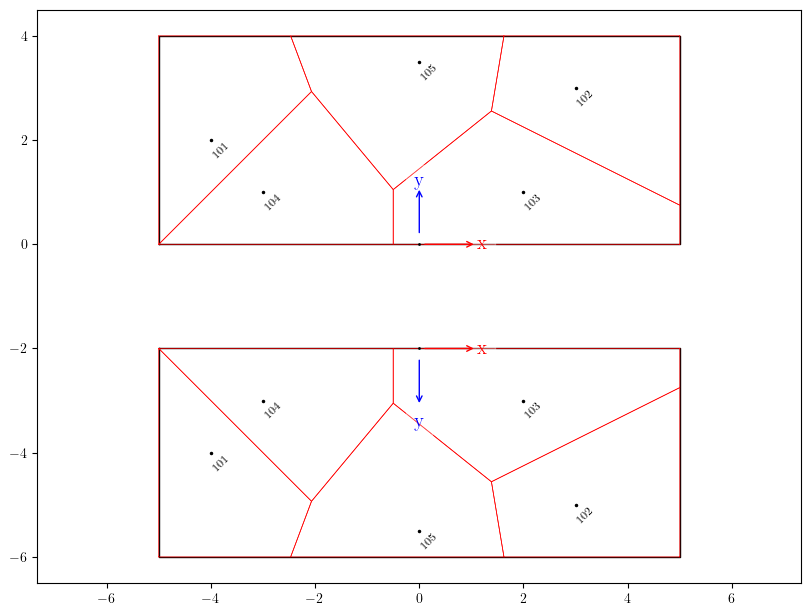

In [20]:
fig = plt.figure(figsize=[8,6])
axs = fig.subplots(1,1)
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

ax = axs
# ax.text(0.5, 0.95, r'(a) Isolated
bldg.plotEdges(ax=ax,showName=False)
bldg.plotTaps(ax=ax,showTapNo=True)
bldg.plotTribs(ax=ax,)
# bldg.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5])
bldg.plotLocalAxes(ax=ax, vectorSize=1.0)
ax.axis('equal')
# ax.axis('off')


In [21]:
print(bldg[0].origin)
print(bldg[0].basisVectors)
print(bldg[0].vertices)
print(bldg[0].vertices3D)

[5, 2, 0]
[[0, 0, -1], [-0.7071067811865475, 0.7071067811865475, 0], [0.7071067811865475, 0.7071067811865475, 0]]
[[-5.  0.]
 [ 5.  0.]
 [ 5.  4.]
 [-5.  4.]
 [-5.  0.]]
[[ 5.          2.          5.        ]
 [ 5.          2.         -5.        ]
 [ 2.17157288  4.82842712 -5.        ]
 [ 2.17157288  4.82842712  5.        ]
 [ 5.          2.          5.        ]]


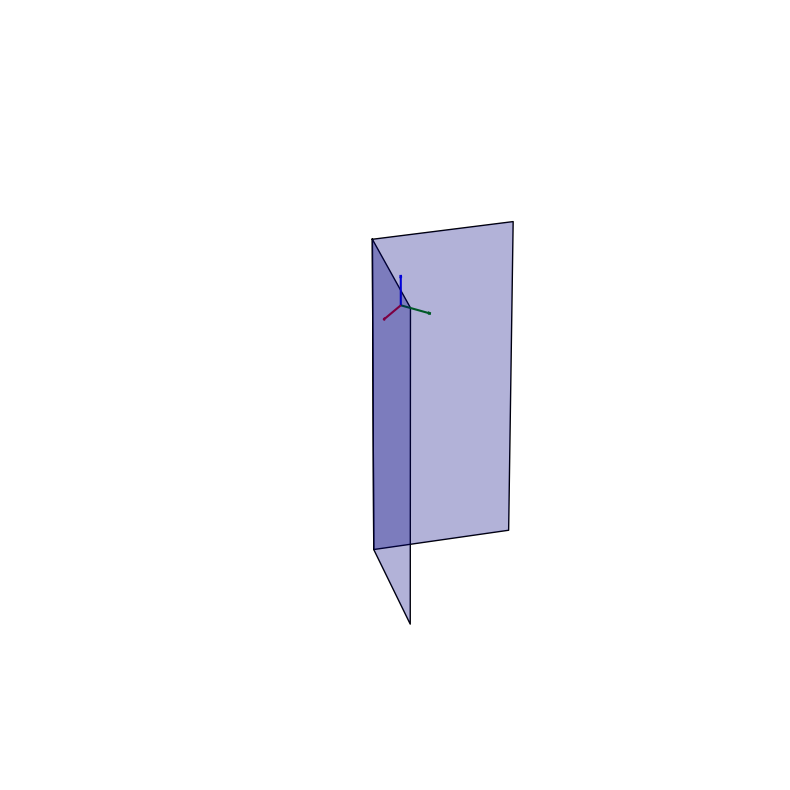

In [22]:
bldg.plotBldg_3D()